In [29]:
### CSE 544 : Probability and Statistics 
### Hypothesis #1: Time Series Analysis
### CSE544-ProbStats-TimeSeriesAnalysis-CrimeData-All Boros 2017


In [30]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.mlab as mlab
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [31]:
## Configurable Parameters:
BORO_IN_QUESTION = 'BROOKLYN' 
'''
LEGITIMATE VALUES FOR BORO_IN_QUESTION:
BRONX            
BROOKLYN         
MANHATTAN        
QUEENS            
STATEN ISLAND     
'''

## constants to be used for charting 
train_test_split_indx=8424 # last 2 weeks for test.


In [32]:
# load data file
data_file = "./data/NYPD_Complaint_Data_2017only.csv"

df = pd.read_csv(data_file, header=0)#, date_parser=parser)
df.head()



,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,579468609,12/31/2017,23:55:00,NaN,NaN,12/31/2017,118,DANGEROUS WEAPONS,792.0,WEAPONS POSSESSION 1 & 2,...,67,NaN,STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822699000,12/31/2017,23:30:00,NaN,NaN,12/31/2017,344,ASSAULT 3 & RELATED OFFENSES,114.0,OBSTR BREATH/CIRCUL,...,47,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187081621,12/31/2017,23:10:00,12/31/2017,23:15:00,12/31/2017,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,23,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,967006956,12/31/2017,23:05:00,12/31/2017,23:15:00,12/31/2017,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,...,73,INSIDE,RESIDENCE-HOUSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,524297993,12/31/2017,23:00:00,NaN,NaN,12/31/2017,118,DANGEROUS WEAPONS,792.0,WEAPONS POSSESSION 1 & 2,...,61,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# gather jurisdiction stats for 2017
boro_df = df.groupby('BORO_NM')
print(boro_df['BORO_NM'].count())


BORO_NM
BRONX            101311
BROOKLYN         134721
MANHATTAN        111652
QUEENS            89518
STATEN ISLAND     20856
Name: BORO_NM, dtype: int64


In [34]:
# dataframe segmentation - BORO-WISE
boro_df = df.loc[df['BORO_NM'] == BORO_IN_QUESTION , ['RPT_DT','CMPLNT_FR_DT','CMPLNT_FR_TM','JURIS_DESC', 'BORO_NM']]
print(boro_df.dtypes)


RPT_DT          object
CMPLNT_FR_DT    object
CMPLNT_FR_TM    object
JURIS_DESC      object
BORO_NM         object
dtype: object


In [35]:
boro_ts_df = pd.DataFrame(pd.DatetimeIndex(boro_df['CMPLNT_FR_DT'] + ' ' + boro_df['CMPLNT_FR_TM'],
                                             format='%m/%d/%Y %H:%M:%S'), dtype='datetime64').sort_index(ascending=False, 
                                                                                                         kind='quicksort')

boro_ts_df.head()

,0
134720,2017-01-01 00:00:00
134719,2017-01-01 00:00:00
134718,2017-01-01 00:00:00
134717,2017-01-01 00:00:00
134716,2017-01-01 00:01:00


In [36]:
boro_ts_df.dtypes

0    datetime64[ns]
dtype: object

In [37]:
boro_ts_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 134721 entries, 134720 to 0
Data columns (total 1 columns):
0    134721 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.1 MB


In [38]:
#index needs to be converted from int64 to datetime64 for timegrouper to work

boro_ts_df['hourly'] = pd.to_datetime(boro_ts_df[0], format='%Y-%m-%d %H:%M:%S') 
boro_ts_df.set_index(boro_ts_df['hourly'],inplace=True)
boro_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134721 entries, 2017-01-01 00:00:00 to 2017-12-31 23:55:00
Data columns (total 2 columns):
0         134721 non-null datetime64[ns]
hourly    134721 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 3.1 MB


In [39]:
## add a count of 1 for each timestamp to aggregate the number of crimes occuring by the hour
boro_ts_df['numCases']=1


In [40]:
boro_grpd_byhour = boro_ts_df.groupby(pd.Grouper(freq='1H', closed = 'left')).aggregate(np.sum) #,
boro_grpd_byhour[:10] # first 10 entries of the year
max_crimes_rpt_day = max(boro_grpd_byhour['numCases']) + 5 # y-axis limit in graph

In [41]:
# Crimes by the hour in a Boro over entire of 2017
df_boro_2017=boro_ts_df.groupby(boro_ts_df.index.map(lambda t: t.hour))
#print(df2)
crimes_by_hour = list()
for i in range(0,24):
    crimes_by_hour.append(df_boro_2017.count()['numCases'][i])

print("Crimes by the hour >> ",crimes_by_hour)

Crimes by the hour >>  [6756, 4529, 3551, 3059, 2528, 2004, 2267, 3039, 4862, 5059, 5544, 5538, 7192, 6310, 7160, 7494, 7607, 7879, 8072, 7661, 7396, 6821, 6437, 5956]


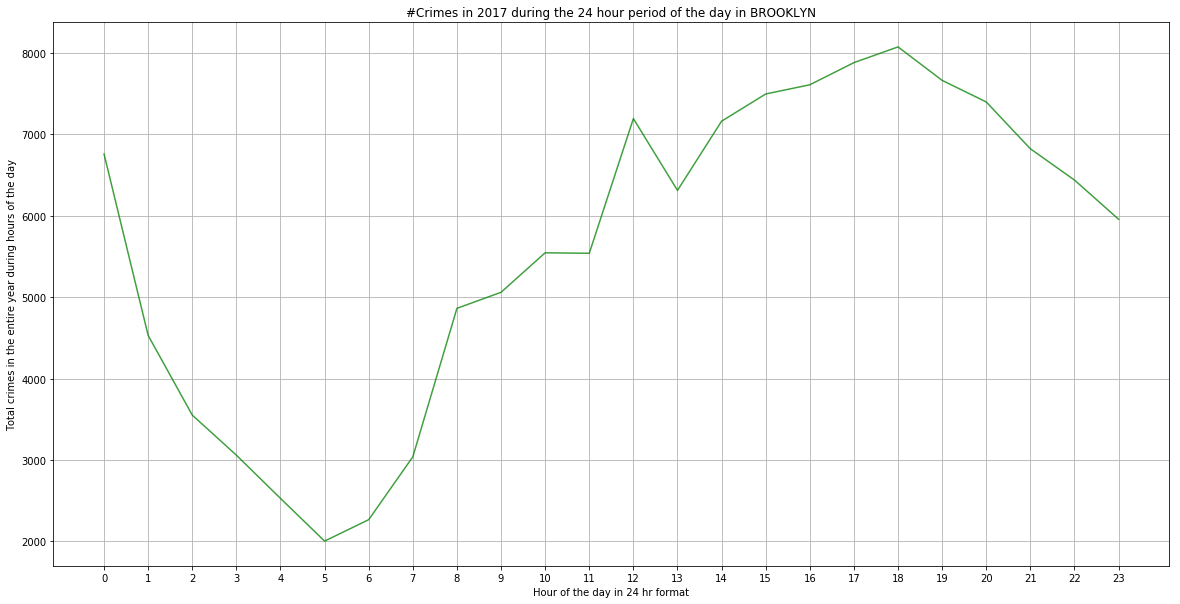

In [42]:
# Plot the total crimes in the entire year during hours of the day
plt.figure(figsize=(20,10))
xvalues = range(0,24,1)
plt.plot(xvalues,crimes_by_hour, color='green', alpha=0.75)

plt.xlabel('Hour of the day in 24 hr format')
xticks = np.arange(0,24,1)
plt.xticks(xticks)
plt.ylabel('Total crimes in the entire year during hours of the day')
plt.title('#Crimes in 2017 during the 24 hour period of the day in '+BORO_IN_QUESTION)

plt.grid(True)
plt.savefig("2017Crimes_"+BORO_IN_QUESTION +".png", dpi=300)
plt.show()

In [43]:
# separate into training and testing set
traindf = boro_grpd_byhour[0:train_test_split_indx] # trained on last 11 month and 2 weeks
testdf = boro_grpd_byhour[train_test_split_indx:] # predicting next 2 weeks 

rec_count = int(boro_grpd_byhour.count())
print("Total records ", rec_count) # 365 days * 24 hours = 8760 records (every hour)


Total records  8760


In [44]:
def show_plot(Y1, Y2, label):
    '''
        Y1:  original/actual value in red
        Y2:  predicted value in blue
        label: parameter value to be plugged into label
    '''
    

    plt.figure(figsize=(20,10))
    plt.title(label)
    yvalues = np.arange(0,max_crimes_rpt_day,5)
    
    xvalues = np.arange(0,testdf.count() , 1)
    xticks = np.arange(0,testdf.count() - 1,12)
    plt.xticks(xticks)
    plt.xlim(0, xvalues[-1])
    plt.xlabel('Last 2 weeks - every hour #')

    plt.yticks(yvalues)
    plt.ylim(0, yvalues[-1])
    plt.ylabel('Actual and Predicted #Crimes for last 2 weeks')
    
    plt.plot(xvalues, Y1, 'r', label = "Original Values")
    plt.plot(xvalues, Y2, 'b', label = "Predicted Values")
    
    legend = plt.legend(loc='upper center', shadow=True) #, fontsize='x-large'

    plt.savefig(BORO_IN_QUESTION + "_"+label+".png", dpi=300)
    plt.show()

In [45]:
def calculate_ewma(alpha, y_t, y_hat_t, count_last_smpl):
    '''
        alpha:  represents the alpha value for ewma
        y_t:    intially it is set to last known training value, then after every iteration it is set to next predicted value
        count_last_smpl : represents the last # training sample
    '''
    
    count = 0 
    actual = testdf['numCases']
    predicted = list()
    while count < (rec_count - count_last_smpl):
        y_hat_tplus1 = alpha * y_t + (1 - alpha) * y_hat_t 
        #print(y_hat_tplus1)
        # add to lists
        #print("y_t ", y_t)
        #print("y_hat_tplus1 ", y_hat_tplus1)
        predicted.append(y_hat_tplus1)
        
        # increment for next rec
        #print(y_t)
        
        y_t = actual[count-1]
        
        y_hat_t = y_hat_tplus1
        count += 1;
    
    #print("Average Error for test samples  >>>>>>>> ", np.sum(avg_error)/testdf.count())
    error = np.sqrt(mean_squared_error(actual, predicted))
    print('Test RMSE: %.3f' % error)
    show_plot(actual, predicted, "EWMA_alpha_"+str(alpha))
    return error
    

Test RMSE: 13.155


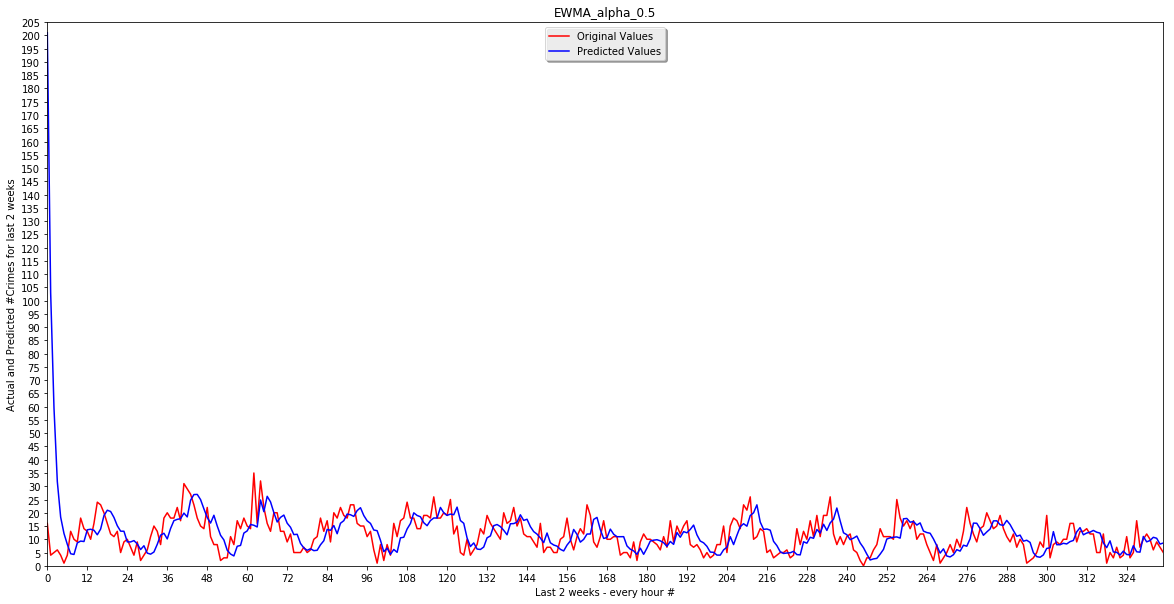

In [46]:
### EWMA alpha =0.5
rmse_ewma_5 = calculate_ewma(0.5, traindf['numCases'][0], traindf['numCases'][0],train_test_split_indx)

Test RMSE: 11.741


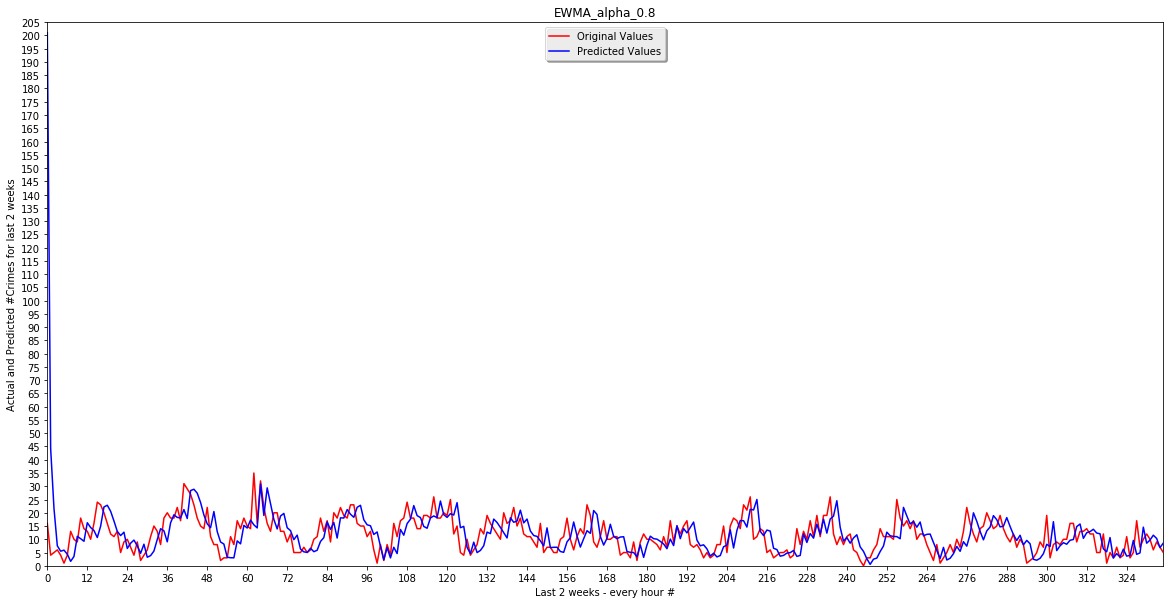

In [47]:
### EWMA alpha =0.8
rmse_ewma_8 = calculate_ewma(0.8, traindf['numCases'][0], traindf['numCases'][0],train_test_split_indx)

In [48]:
def create_Xtrain(p, strt_indx):
    '''
    Pre-process and form the X train data to train the model and calculate beta values
    '''
    trn_rows = strt_indx - 1  #int(traindf.count())
    Xtrain = np.ones(((trn_rows - p), p))
    for row in range (0, (trn_rows - p)):
        for col in range(0,p):
            Xtrain[row][col] = boro_grpd_byhour['numCases'].iloc[trn_rows - row - col - 2]
    
    return Xtrain
    

In [49]:
def create_ytrain(p, strt_indx):
    '''
    Pre-process and form the Y train data to train the model and calculate beta values
    '''
    trn_rows = strt_indx - 1 #int(traindf.count())
    ytrain = list()#np.ones(((trn_rows - p),1))
    
    for row in range (0, (trn_rows - p)):
        ytrain.append(boro_grpd_byhour['numCases'].iloc[trn_rows - row - 1])
    
    y = np.array(ytrain)
    return y

In [50]:
def calculate_betas(p, strt_indx):
    model = linear_model.LinearRegression()
    model.fit(create_Xtrain(p, strt_indx), create_ytrain(p, strt_indx))
    #print("Coefficients / Beta Values :: \n",model.coef_)
    #print("Intercept :: \n", model.intercept_ )
    return (model.intercept_, model.coef_)

In [51]:
def calculate_AR(p, t):
    '''
    p:
    t:
    '''
    
    count = 0
    predicted = list()
    actual = testdf['numCases']
    beta_0, betas = calculate_betas(p, t)
    while count < rec_count - t:
        y_hat_tplus1 = beta_0
        for i in range(0,p):
            y_hat_tplus1 += betas[i] * boro_grpd_byhour['numCases'].iloc[t + count-i - 1]

        predicted.append(y_hat_tplus1)
        count += 1
        beta_0, betas = calculate_betas(p,t + count)

    error = np.sqrt(mean_squared_error(actual, predicted))
    print('Test RMSE: %.3f' % error)
    show_plot(actual, predicted, "AR_p_"+str(p))
    return error
    

Test RMSE: 4.949


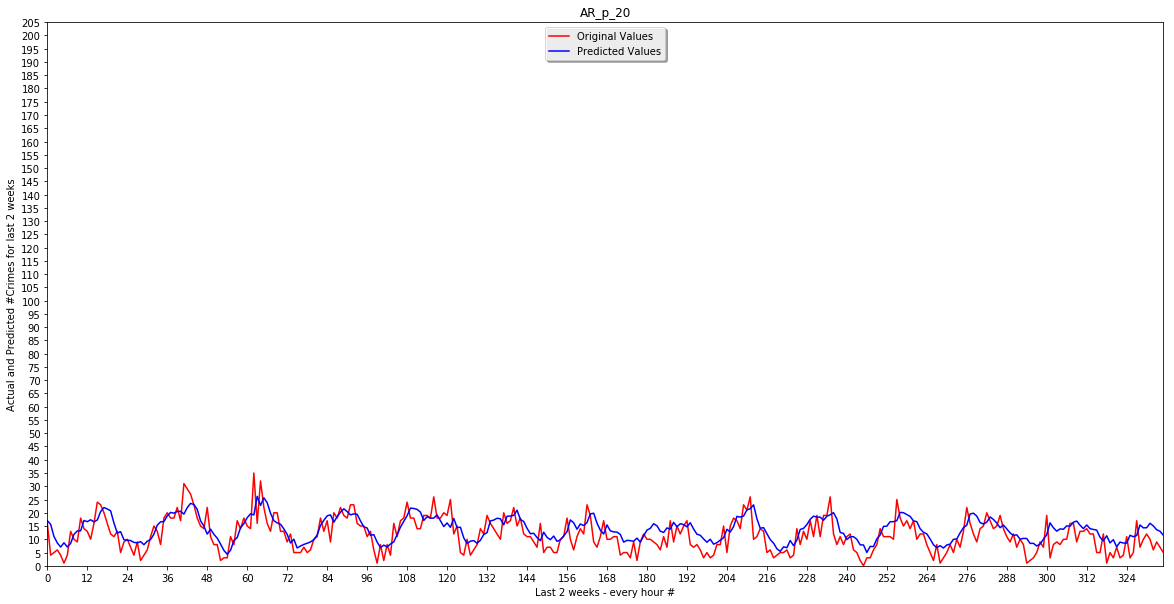

In [52]:
#AR(p=20)
rmse_ar_20 = calculate_AR(20,train_test_split_indx)


Test RMSE: 4.887


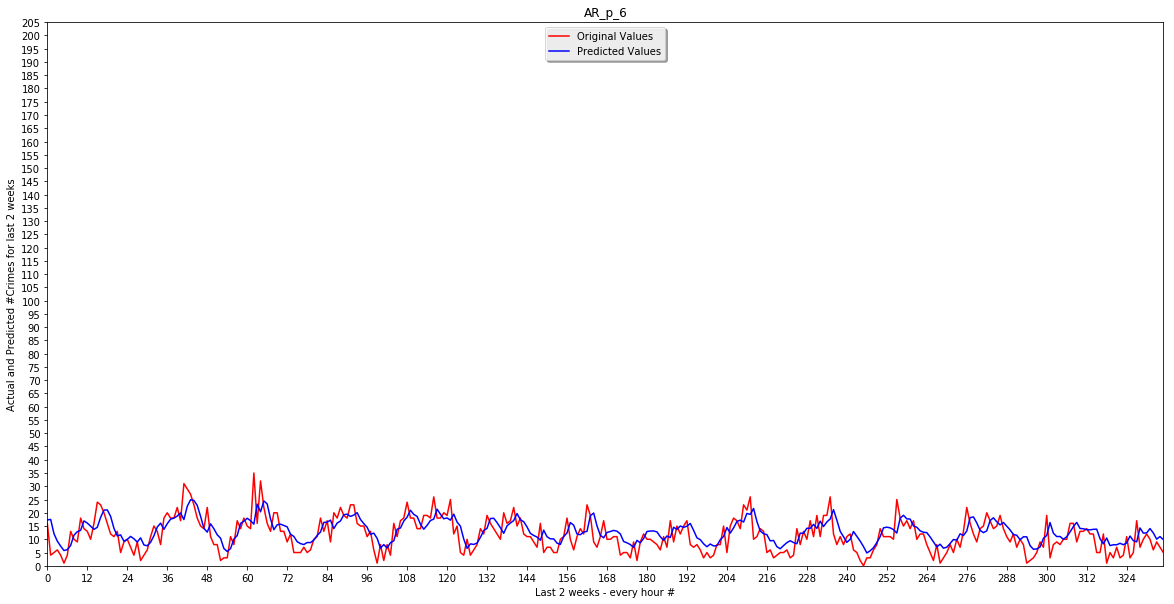

In [53]:
#AR(p=6)
rmse_ar_6 = calculate_AR(6,train_test_split_indx)

In [54]:
def call_arima(p,d,q):
    '''
    Arima with rolling forecast
    '''
    actual = testdf['numCases']
    history = [float(x) for x in traindf['numCases']]
    predicted = list()
    for t in range(len(testdf)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predicted.append(yhat)
        obs = actual[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = np.sqrt(mean_squared_error(actual, predicted))
    print('Test RMSE: %.3f' % error)
    show_plot(actual, predicted, "ARIMA_p_"+str(p) + "_d_"+ str(d) + "_q_" + str(q))
    return error

Test RMSE: 4.915


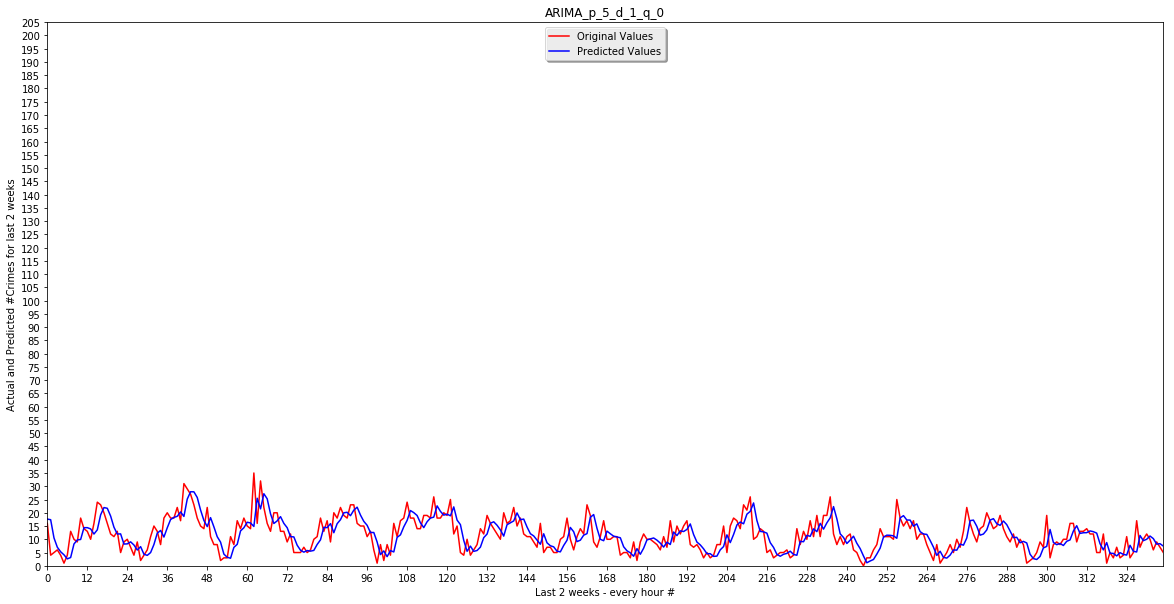

In [55]:
# Arima 510
rmse_arima_510 = call_arima(5,1,0)

In [56]:
# tabulate the errors obtained from each of the methods attempted
from IPython.display import HTML, display
import tabulate
table = [["EWMA(alpha=0.5)",rmse_ewma_5],
         ["EWMA(alpha=0.8)",rmse_ewma_8],
         ["AR(p=20)",rmse_ar_20],
         ["AR(p=6)",rmse_ar_6],
         ["ARIMA(p=5,q=1,d=0)",rmse_arima_510]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

EWMA(alpha=0.5),13.1551
EWMA(alpha=0.8),11.7411
AR(p=20),4.94854
AR(p=6),4.88691
"ARIMA(p=5,q=1,d=0)",4.91476
